In [1]:
import os
import pandas as pd

# Set the paths to the spam and ham folders
spam_folder = '/content/drive/MyDrive/enron1/spam'
ham_folder = '/content/drive/MyDrive/enron1/ham'

# Read all spam emails
spam_emails = []
for filename in os.listdir(spam_folder):
    with open(os.path.join(spam_folder, filename), 'r', encoding='latin1') as file:
        spam_emails.append(file.read())

# Read all ham emails
ham_emails = []
for filename in os.listdir(ham_folder):
    with open(os.path.join(ham_folder, filename), 'r', encoding='latin1') as file:
        ham_emails.append(file.read())

# Create a DataFrame
data = pd.DataFrame({
    'text': spam_emails + ham_emails,
    'label': ['spam'] * len(spam_emails) + ['ham'] * len(ham_emails)
})


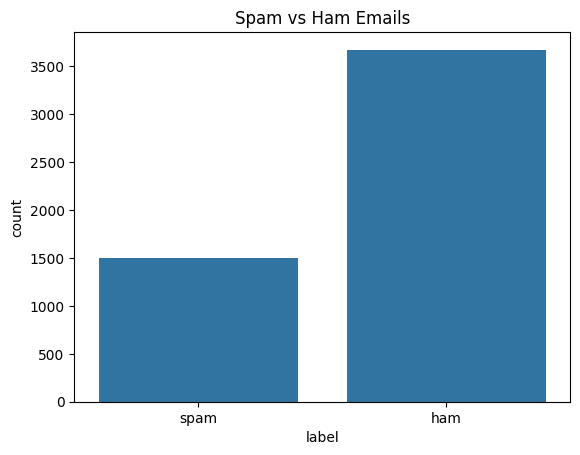

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display the label distribution
sns.countplot(x='label', data=data)
plt.title('Spam vs Ham Emails')
plt.show()


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download necessary NLTK data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove email headers
    text = re.sub(r"From:.*\n|To:.*\n|Subject:.*\n", "", text)
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stop words
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['cleaned_text'] = data['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['cleaned_text'])
X = tokenizer.texts_to_sequences(data['cleaned_text'])

# Pad sequences to ensure uniform input size
X = pad_sequences(X, padding='post', maxlen=100)

# Encode labels
y = data['label'].apply(lambda x: 1 if x == 'spam' else 0).values


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.7022 - loss: 0.6179 - val_accuracy: 0.7420 - val_loss: 0.4019
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.7769 - loss: 0.3561 - val_accuracy: 0.8396 - val_loss: 0.3593
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.8536 - loss: 0.3208 - val_accuracy: 0.8937 - val_loss: 0.3072
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8727 - loss: 0.2774 - val_accuracy: 0.7932 - val_loss: 0.3559
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.8798 - loss: 0.2860 - val_accuracy: 0.7266 - val_loss: 0.5812


In [7]:
from sklearn.metrics import accuracy_score

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Accuracy: 0.7266


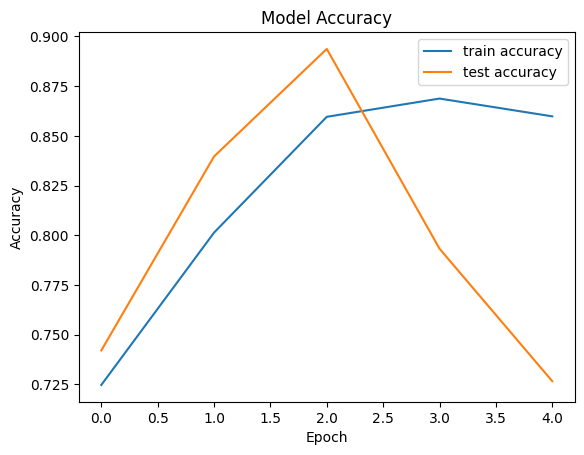

In [8]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()